# Efficiency from SSM

## Tutorial that shows how to use GW_models.py and hydro_bubbles.py to compute the efficiency of GW production according to the sound-shell model.

### It follows the assumptions presented in HH19: *Hindmarsh & Hijazi*, JCAP 12 (2019) 062, arXiv:1909.10040, see Appendix B of RPPC23: Roper Pol et al., Phys. Rev. D 109 (2024) 6, 063531, arXiv:2308.12943 for details

### Created by Alberto Roper Pol (alberto.roperpol@unige.ch), 29/08/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
HOME = os.getcwd()

os.chdir('../..')
import plot_sets
import hydro_bubbles as hb
import GW_models
os.chdir(HOME)

# reference values
cs2 = 1/3
cs = np.sqrt(cs2)

# reference colors
cols = hb.cols_ref

In [2]:
### compute the 1d profiles of the fluid perturbations

## we first compute the 1d profiles (velocity and energy fluctuations lambda)
## for a chosen alpha and range of vws

alpha = 0.0046
vws = np.linspace(0.32, .8, 13)
# define string of vws for saving file
str_vws = ['032', '036', '04', '044', '048', '052', '056', '06', '064', '068', '072', '076', '08']
str_alp = '00046'
Nxi = 10000

xis, vvs, lams, alphapl, conv, shocks, xifs, wms, kappas, omegas = \
       hb.compute_profiles_vws(alpha, vws=vws, cs2=cs2, plot=False, plot_v='both', cols=[], meth=2,
                               alphan=True, lam=True, eff=True, quiet=True, tol=1e-5, max_it=30, Nxi=Nxi, Nxi2=2*Nxi,
                               save=True, strs_vws=str_vws, str_alp=str_alp)

types = hb.type_nucleation(vws, alpha, cs2=cs2)

3 iterations for vw= 0.32  and alpha=  0.0046
alpha: 0.0046000049694327055 , alpha_+: 0.004552950606229703
results of 1d profile saved in  results/1d_profiles/alpha_00046_vw_032.csv
3 iterations for vw= 0.36  and alpha=  0.0046
alpha: 0.004600012549210328 , alpha_+: 0.004536001538899887
results of 1d profile saved in  results/1d_profiles/alpha_00046_vw_036.csv
3 iterations for vw= 0.4  and alpha=  0.0046
alpha: 0.004600032407470411 , alpha_+: 0.004512256077478789
results of 1d profile saved in  results/1d_profiles/alpha_00046_vw_04.csv
4 iterations for vw= 0.44  and alpha=  0.0046
alpha: 0.004599997645495893 , alpha_+: 0.004476619531355962
results of 1d profile saved in  results/1d_profiles/alpha_00046_vw_044.csv
4 iterations for vw= 0.48  and alpha=  0.0046
alpha: 0.004599989328945599 , alpha_+: 0.004417867883061105
results of 1d profile saved in  results/1d_profiles/alpha_00046_vw_048.csv
5 iterations for vw= 0.52  and alpha=  0.0046
alpha: 0.004600003447411667 , alpha_+: 0.004306550

In [3]:
# we now compute the f'2 function from the 1d profiles that will be used to compute
# the kinetic spectrum

Nz = 5000
z_min = -2
z_max = 5
z = np.logspace(z_min, z_max, Nz)
fpzs, lzs = hb.fp_z(xis, vvs, z, ls=lams, multi=True, quiet=False, lz=True)

vw  1 / 13  computed
vw  2 / 13  computed
vw  3 / 13  computed
vw  4 / 13  computed
vw  5 / 13  computed
vw  6 / 13  computed
vw  7 / 13  computed
vw  8 / 13  computed
vw  9 / 13  computed
vw  10 / 13  computed
vw  11 / 13  computed
vw  12 / 13  computed
vw  13 / 13  computed


In [4]:
# compute power spectral density as a function of q/beta using the sound-shell model
# and exponential nucleation

Nqbeta = 1000

q_beta, Pv_exp = GW_models.compute_kin_spec_dens(z, vws, fpzs, lzs, sp='sum', type_n='exp', cs2=cs2,
                                  min_qbeta=-2, max_qbeta=3, Nqbeta=Nqbeta,
                                  min_TT=-1, max_TT=3, NTT=5000)

In [5]:
## compute the spectrum EK and kR in terms of the power spectral density Pv and q/beta

kks, EK_exp = GW_models.compute_kin_spec(vws, q_beta, Pv_exp, corr=True, cs2=cs2)

In [7]:
#### computation of the GW efficiency under the assumptions taken in HH19,
#### corrected in RPPC23, and described in App. B of RPPC23

Nk = 120
Np = 3000

# OmGW^HH(k) = (3pi)/8cs x (k/kst)^2 x (K/KK)^2 x TGW x Omm(k)

zetaGW_HH = np.zeros((len(vws), Nk))
OmGW_HH = np.zeros((len(vws), Nk))
Omtilde_HH = np.zeros(len(vws))
kps = np.zeros((len(vws), Nk))
    
for i in range(0, len(vws)):

    zeta_EK = EK_exp[i, :]/max(EK_exp[i, :])
    KK = np.trapz(zeta_EK, kks[i, :])
    kps[i, :], OmGW_HH[i, :] = GW_models.OmGW_ssm_HH19(kks[i, :], zeta_EK, Np=Np, Nk=Nk, plot=False, cs2=cs2)
    
    zetaGW_HH[i, :] = np.pi/8*kps[i, :]**2/cs*OmGW_HH[i, :]/KK**2
    Omtilde_HH[i] = np.trapz(zetaGW_HH[i, :], np.log(kps[i, :]))

Text(0.5, 1.0, '$\\alpha = 0.0046$')

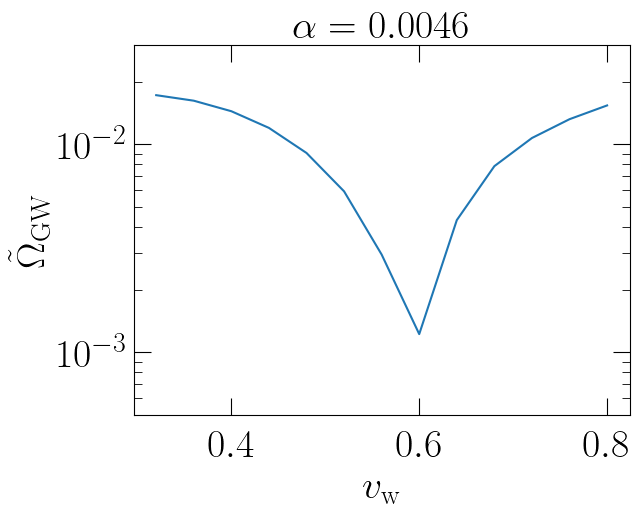

In [12]:
### We can now plot the efficiency Omega_tilde vs vw

plt.plot(vws, Omtilde_HH)
plt.yscale('log')
plot_sets.axes_lines()

plt.ylim(5e-4, 3e-2)
plt.xlabel(r'$v_{\rm w}$')
plt.ylabel(r'$\tilde \Omega_{\rm GW}$')
plt.title(r'$\alpha = 0.0046$')